In [24]:
import torch
import torch.utils.data as data
import torchvision.transforms as transforms

from PIL import Image, ImageDraw

import os.path as osp
import numpy as np
import json

import argparse
import os
import time

from IPython.display import display

In [9]:
def get_opt():
    parser = argparse.ArgumentParser()

    parser.add_argument("--gpu_ids", default="0")
    parser.add_argument("-j", "--workers", type=int, default=0)
    parser.add_argument("-b", "--batch-size", type=int, default=1)
    parser.add_argument("--fp16", action="store_true", help="use amp")
    # Cuda availability
    parser.add_argument("--cuda", default=True, help="cuda or cpu")

    parser.add_argument("--test_name", type=str, default="test", help="test name")
    parser.add_argument("--dataroot", default="./data/zalando-hd-resized")
    parser.add_argument("--datamode", default="test")
    parser.add_argument("--data_list", default="test_pairs.txt")
    parser.add_argument("--output_dir", type=str, default="./Output")
    parser.add_argument("--datasetting", default="unpaired")
    parser.add_argument("--fine_width", type=int, default=768)
    parser.add_argument("--fine_height", type=int, default=1024)

    parser.add_argument(
        "--tensorboard_dir",
        type=str,
        default="./data/zalando-hd-resized/tensorboard",
        help="save tensorboard infos",
    )
    parser.add_argument(
        "--checkpoint_dir",
        type=str,
        default="checkpoints",
        help="save checkpoint infos",
    )
    parser.add_argument(
        "--tocg_checkpoint",
        type=str,
        default="./eval_models/weights/v0.1/mtviton.pth",
        help="tocg checkpoint",
    )
    parser.add_argument(
        "--gen_checkpoint",
        type=str,
        default="./eval_models/weights/v0.1/gen.pth",
        help="G checkpoint",
    )

    parser.add_argument("--tensorboard_count", type=int, default=100)
    parser.add_argument("--shuffle", action="store_true", help="shuffle input data")
    parser.add_argument("--semantic_nc", type=int, default=13)
    parser.add_argument("--output_nc", type=int, default=13)
    parser.add_argument(
        "--gen_semantic_nc",
        type=int,
        default=7,
        help="# of input label classes without unknown class",
    )

    # network
    parser.add_argument("--warp_feature", choices=["encoder", "T1"], default="T1")
    parser.add_argument("--out_layer", choices=["relu", "conv"], default="relu")

    # training
    parser.add_argument(
        "--clothmask_composition",
        type=str,
        choices=["no_composition", "detach", "warp_grad"],
        default="warp_grad",
    )

    # Hyper-parameters
    parser.add_argument(
        "--upsample", type=str, default="bilinear", choices=["nearest", "bilinear"]
    )
    parser.add_argument("--occlusion", action="store_false", help="Occlusion handling")

    # generator
    parser.add_argument(
        "--norm_G",
        type=str,
        default="spectralaliasinstance",
        help="instance normalization or batch normalization",
    )
    parser.add_argument(
        "--ngf", type=int, default=64, help="# of gen filters in first conv layer"
    )
    parser.add_argument(
        "--init_type",
        type=str,
        default="xavier",
        help="network initialization [normal|xavier|kaiming|orthogonal]",
    )
    parser.add_argument(
        "--init_variance",
        type=float,
        default=0.02,
        help="variance of the initialization distribution",
    )
    parser.add_argument(
        "--num_upsampling_layers",
        choices=("normal", "more", "most"),
        default="most",  # normal: 256, more: 512
        help="If 'more', adds upsampling layer between the two middle resnet blocks. If 'most', also add one more upsampling + resnet layer at the end of the generator",
    )

    opt = parser.parse_args("")
    return opt

In [4]:
class CPDatasetTest(data.Dataset):
    """
        Test Dataset for CP-VTON.
    """
    def __init__(self, opt):
        super(CPDatasetTest, self).__init__()
        # base setting
        self.opt = opt
        self.root = opt.dataroot
        self.datamode = opt.datamode # train or test or self-defined
        self.data_list = opt.data_list
        self.fine_height = opt.fine_height
        self.fine_width = opt.fine_width
        self.semantic_nc = opt.semantic_nc
        self.data_path = osp.join(opt.dataroot, opt.datamode)
        self.transform = transforms.Compose([  \
                transforms.ToTensor(),   \
                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

        # load data list
        im_names = []
        c_names = []
        with open(osp.join(opt.dataroot, opt.data_list), 'r') as f:
            for line in f.readlines():
                im_name, c_name = line.strip().split()
                im_names.append(im_name)
                c_names.append(c_name)

        self.im_names = im_names
        self.c_names = dict()
        self.c_names['paired'] = im_names
        self.c_names['unpaired'] = c_names

    def name(self):
        return "CPDataset"

    def get_agnostic(self, im, im_parse, pose_data):
        parse_array = np.array(im_parse)
        parse_head = ((parse_array == 4).astype(np.float32) +
                      (parse_array == 13).astype(np.float32))
        parse_lower = ((parse_array == 9).astype(np.float32) +
                       (parse_array == 12).astype(np.float32) +
                       (parse_array == 16).astype(np.float32) +
                       (parse_array == 17).astype(np.float32) +
                       (parse_array == 18).astype(np.float32) +
                       (parse_array == 19).astype(np.float32))

        agnostic = im.copy()
        agnostic_draw = ImageDraw.Draw(agnostic)

        length_a = np.linalg.norm(pose_data[5] - pose_data[2])
        length_b = np.linalg.norm(pose_data[12] - pose_data[9])
        point = (pose_data[9] + pose_data[12]) / 2
        pose_data[9] = point + (pose_data[9] - point) / length_b * length_a
        pose_data[12] = point + (pose_data[12] - point) / length_b * length_a

        r = int(length_a / 16) + 1

        # mask torso
        for i in [9, 12]:
            pointx, pointy = pose_data[i]
            agnostic_draw.ellipse((pointx-r*3, pointy-r*6, pointx+r*3, pointy+r*6), 'gray', 'gray')
        agnostic_draw.line([tuple(pose_data[i]) for i in [2, 9]], 'gray', width=r*6)
        agnostic_draw.line([tuple(pose_data[i]) for i in [5, 12]], 'gray', width=r*6)
        agnostic_draw.line([tuple(pose_data[i]) for i in [9, 12]], 'gray', width=r*12)
        agnostic_draw.polygon([tuple(pose_data[i]) for i in [2, 5, 12, 9]], 'gray', 'gray')

        # mask neck
        pointx, pointy = pose_data[1]
        agnostic_draw.rectangle((pointx-r*5, pointy-r*9, pointx+r*5, pointy), 'gray', 'gray')

        # mask arms
        agnostic_draw.line([tuple(pose_data[i]) for i in [2, 5]], 'gray', width=r*12)
        for i in [2, 5]:
            pointx, pointy = pose_data[i]
            agnostic_draw.ellipse((pointx-r*5, pointy-r*6, pointx+r*5, pointy+r*6), 'gray', 'gray')
        for i in [3, 4, 6, 7]:
            if (pose_data[i-1, 0] == 0.0 and pose_data[i-1, 1] == 0.0) or (pose_data[i, 0] == 0.0 and pose_data[i, 1] == 0.0):
                continue
            agnostic_draw.line([tuple(pose_data[j]) for j in [i - 1, i]], 'gray', width=r*10)
            pointx, pointy = pose_data[i]
            agnostic_draw.ellipse((pointx-r*5, pointy-r*5, pointx+r*5, pointy+r*5), 'gray', 'gray')

        for parse_id, pose_ids in [(14, [5, 6, 7]), (15, [2, 3, 4])]:
            mask_arm = Image.new('L', (768, 1024), 'white')
            mask_arm_draw = ImageDraw.Draw(mask_arm)
            pointx, pointy = pose_data[pose_ids[0]]
            mask_arm_draw.ellipse((pointx-r*5, pointy-r*6, pointx+r*5, pointy+r*6), 'black', 'black')
            for i in pose_ids[1:]:
                if (pose_data[i-1, 0] == 0.0 and pose_data[i-1, 1] == 0.0) or (pose_data[i, 0] == 0.0 and pose_data[i, 1] == 0.0):
                    continue
                mask_arm_draw.line([tuple(pose_data[j]) for j in [i - 1, i]], 'black', width=r*10)
                pointx, pointy = pose_data[i]
                if i != pose_ids[-1]:
                    mask_arm_draw.ellipse((pointx-r*5, pointy-r*5, pointx+r*5, pointy+r*5), 'black', 'black')
            mask_arm_draw.ellipse((pointx-r*4, pointy-r*4, pointx+r*4, pointy+r*4), 'black', 'black')

            parse_arm = (np.array(mask_arm) / 255) * (parse_array == parse_id).astype(np.float32)
            agnostic.paste(im, None, Image.fromarray(np.uint8(parse_arm * 255), 'L'))

        agnostic.paste(im, None, Image.fromarray(np.uint8(parse_head * 255), 'L'))
        agnostic.paste(im, None, Image.fromarray(np.uint8(parse_lower * 255), 'L'))
        return agnostic
        
    def __getitem__(self, index):
        im_name = self.im_names[index]
        c_name = {}
        c = {}
        cm = {}
        for key in self.c_names:
            c_name[key] = self.c_names[key][index]
            c[key] = Image.open(osp.join(self.data_path, 'cloth', c_name[key])).convert('RGB')
            c[key] = transforms.Resize(self.fine_width, interpolation=2)(c[key])
            cm[key] = Image.open(osp.join(self.data_path, 'cloth-mask', c_name[key]))
            cm[key] = transforms.Resize(self.fine_width, interpolation=0)(cm[key])

            c[key] = self.transform(c[key])  # [-1,1]
            cm_array = np.array(cm[key])
            cm_array = (cm_array >= 128).astype(np.float32)
            cm[key] = torch.from_numpy(cm_array)  # [0,1]
            cm[key].unsqueeze_(0)

        # person image
        im_pil_big = Image.open(osp.join(self.data_path, 'image', im_name))
        im_pil = transforms.Resize(self.fine_width, interpolation=2)(im_pil_big)
        
        im = self.transform(im_pil)

        # load parsing image
        parse_name = im_name.replace('.jpg', '.png')
        im_parse_pil_big = Image.open(osp.join(self.data_path, 'image-parse-v3', parse_name))
        im_parse_pil = transforms.Resize(self.fine_width, interpolation=0)(im_parse_pil_big)
        parse = torch.from_numpy(np.array(im_parse_pil)[None]).long()
        im_parse = self.transform(im_parse_pil.convert('RGB'))
        
        labels = {
            0:  ['background',  [0, 10]],
            1:  ['hair',        [1, 2]],
            2:  ['face',        [4, 13]],
            3:  ['upper',       [5, 6, 7]],
            4:  ['bottom',      [9, 12]],
            5:  ['left_arm',    [14]],
            6:  ['right_arm',   [15]],
            7:  ['left_leg',    [16]],
            8:  ['right_leg',   [17]],
            9:  ['left_shoe',   [18]],
            10: ['right_shoe',  [19]],
            11: ['socks',       [8]],
            12: ['noise',       [3, 11]]
        }

        parse_map = torch.FloatTensor(20, self.fine_height, self.fine_width).zero_()
        parse_map = parse_map.scatter_(0, parse, 1.0)
        new_parse_map = torch.FloatTensor(self.semantic_nc, self.fine_height, self.fine_width).zero_()
        
        for i in range(len(labels)):
            for label in labels[i][1]:
                new_parse_map[i] += parse_map[label]
        
        parse_onehot = torch.FloatTensor(1, self.fine_height, self.fine_width).zero_()
        for i in range(len(labels)):
            for label in labels[i][1]:
                parse_onehot[0] += parse_map[label] * i

        # load image-parse-agnostic
        image_parse_agnostic = Image.open(osp.join(self.data_path, 'image-parse-agnostic-v3.2', parse_name))
        image_parse_agnostic = transforms.Resize(self.fine_width, interpolation=0)(image_parse_agnostic)
        parse_agnostic = torch.from_numpy(np.array(image_parse_agnostic)[None]).long()
        image_parse_agnostic = self.transform(image_parse_agnostic.convert('RGB'))

        parse_agnostic_map = torch.FloatTensor(20, self.fine_height, self.fine_width).zero_()
        parse_agnostic_map = parse_agnostic_map.scatter_(0, parse_agnostic, 1.0)
        new_parse_agnostic_map = torch.FloatTensor(self.semantic_nc, self.fine_height, self.fine_width).zero_()
        for i in range(len(labels)):
            for label in labels[i][1]:
                new_parse_agnostic_map[i] += parse_agnostic_map[label]
                

        # parse cloth & parse cloth mask
        pcm = new_parse_map[3:4]
        im_c = im * pcm + (1 - pcm)
        
        # load pose points
        pose_name = im_name.replace('.jpg', '_rendered.png')
        pose_map = Image.open(osp.join(self.data_path, 'openpose_img', pose_name))
        pose_map = transforms.Resize(self.fine_width, interpolation=2)(pose_map)
        pose_map = self.transform(pose_map)  # [-1,1]
        
        pose_name = im_name.replace('.jpg', '_keypoints.json')
        with open(osp.join(self.data_path, 'openpose_json', pose_name), 'r') as f:
            pose_label = json.load(f)
            pose_data = pose_label['people'][0]['pose_keypoints_2d']
            pose_data = np.array(pose_data)
            pose_data = pose_data.reshape((-1, 3))[:, :2]

        
        # load densepose
        densepose_name = im_name.replace('image', 'image-densepose')
        densepose_map = Image.open(osp.join(self.data_path, 'image-densepose', densepose_name))
        densepose_map = transforms.Resize(self.fine_width, interpolation=2)(densepose_map)
        densepose_map = self.transform(densepose_map)  # [-1,1]
        agnostic = self.get_agnostic(im_pil_big, im_parse_pil_big, pose_data)
        agnostic = transforms.Resize(self.fine_width, interpolation=2)(agnostic)
        agnostic = self.transform(agnostic)
        


        result = {
            'c_name':   c_name,     # for visualization
            'im_name':  im_name,    # for visualization or ground truth
            # intput 1 (clothfloww)
            'cloth':    c,          # for input
            'cloth_mask':     cm,   # for input
            # intput 2 (segnet)
            'parse_agnostic': new_parse_agnostic_map,
            'densepose': densepose_map,
            'pose': pose_map,       # for conditioning
            # GT
            'parse_onehot' : parse_onehot,  # Cross Entropy
            'parse': new_parse_map, # GAN Loss real
            'pcm': pcm,             # L1 Loss & vis
            'parse_cloth': im_c,    # VGG Loss & vis
            # visualization
            'image':    im,         # for visualization
            'agnostic' : agnostic
            }
        
        return result

    def __len__(self):
        return len(self.im_names)

In [10]:
opt = get_opt()
print(opt)

Namespace(batch_size=1, checkpoint_dir='checkpoints', clothmask_composition='warp_grad', cuda=True, data_list='test_pairs.txt', datamode='test', dataroot='./data/zalando-hd-resized', datasetting='unpaired', fine_height=1024, fine_width=768, fp16=False, gen_checkpoint='./eval_models/weights/v0.1/gen.pth', gen_semantic_nc=7, gpu_ids='0', init_type='xavier', init_variance=0.02, ngf=64, norm_G='spectralaliasinstance', num_upsampling_layers='most', occlusion=True, out_layer='relu', output_dir='./Output', output_nc=13, semantic_nc=13, shuffle=False, tensorboard_count=100, tensorboard_dir='./data/zalando-hd-resized/tensorboard', test_name='test', tocg_checkpoint='./eval_models/weights/v0.1/mtviton.pth', upsample='bilinear', warp_feature='T1', workers=0)


In [11]:
test_dataset = CPDatasetTest(opt)
test_dataset.__len__()

1

In [14]:
data_json = test_dataset.__getitem__(0)
data_json.keys()

dict_keys(['c_name', 'im_name', 'cloth', 'cloth_mask', 'parse_agnostic', 'densepose', 'pose', 'parse_onehot', 'parse', 'pcm', 'parse_cloth', 'image', 'agnostic'])

In [48]:
data_json['cloth'].keys()

dict_keys(['paired', 'unpaired'])

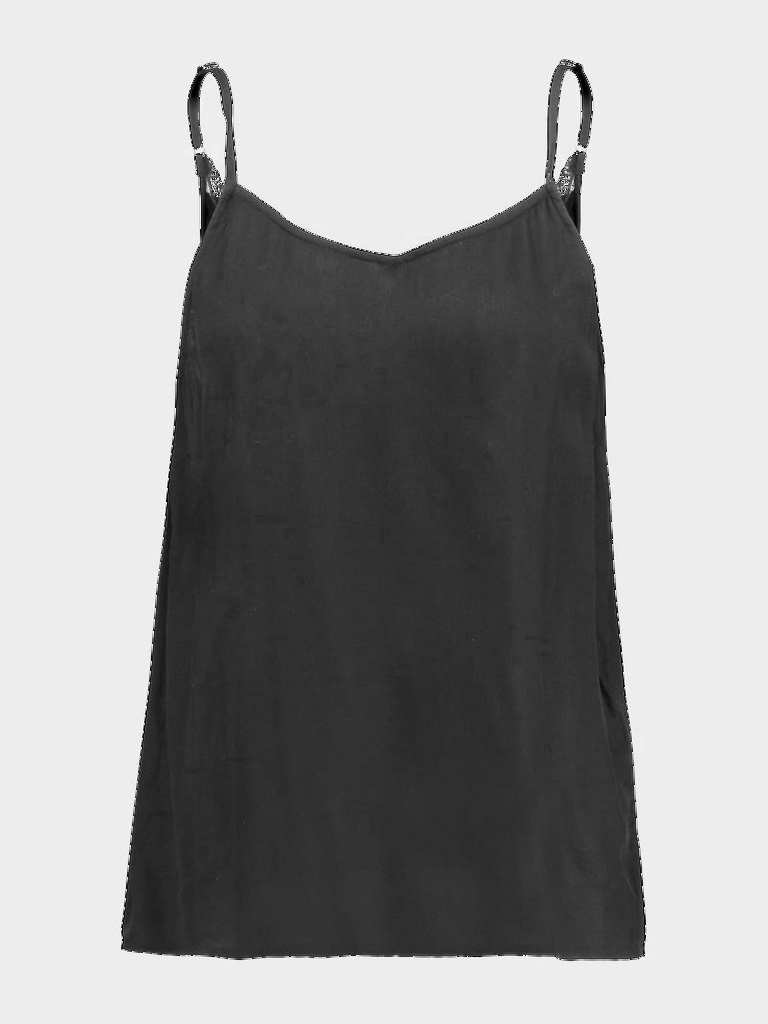

In [49]:
trans = transforms.ToPILImage()
out = trans(data_json['cloth']['unpaired'][0])
display(out)

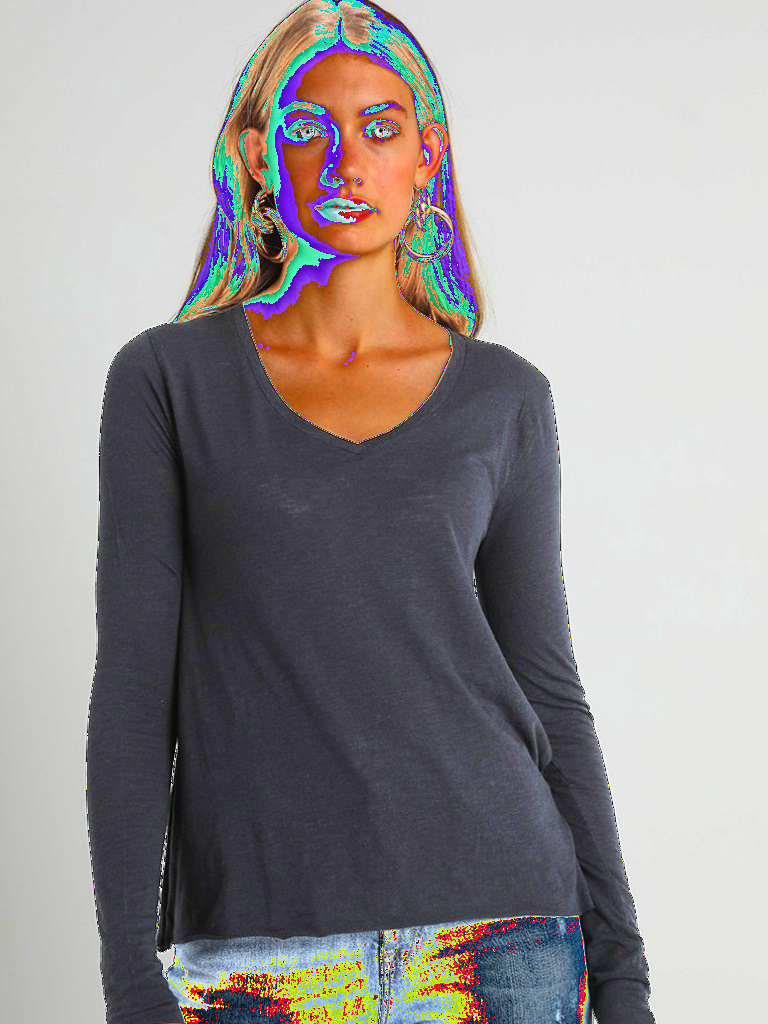

In [52]:
trans = transforms.ToPILImage()
out = trans(data_json['image'])
display(out)

In [53]:
class CPDataLoader(object):
    def __init__(self, opt, dataset):
        super(CPDataLoader, self).__init__()
        if opt.shuffle :
            train_sampler = torch.utils.data.sampler.RandomSampler(dataset)
        else:
            train_sampler = None

        self.data_loader = torch.utils.data.DataLoader(
                dataset, batch_size=opt.batch_size, shuffle=(train_sampler is None),
                num_workers=opt.workers, pin_memory=True, drop_last=True, sampler=train_sampler)
        self.dataset = dataset
        self.data_iter = self.data_loader.__iter__()

    def next_batch(self):
        try:
            batch = self.data_iter.__next__()
        except StopIteration:
            self.data_iter = self.data_loader.__iter__()
            batch = self.data_iter.__next__()

        return batch

In [54]:
test_loader = CPDataLoader(opt, test_dataset)

In [56]:
for inputs in test_loader.data_loader:
    print(inputs)

{'c_name': {'paired': ['00135_00.jpg'], 'unpaired': ['08532_00.jpg']}, 'im_name': ['00135_00.jpg'], 'cloth': {'paired': tensor([[[[0.9294, 0.9294, 0.9294,  ..., 0.9294, 0.9294, 0.9294],
          [0.9294, 0.9294, 0.9294,  ..., 0.9294, 0.9294, 0.9294],
          [0.9294, 0.9294, 0.9294,  ..., 0.9294, 0.9294, 0.9294],
          ...,
          [0.9294, 0.9294, 0.9294,  ..., 0.9294, 0.9294, 0.9294],
          [0.9294, 0.9294, 0.9294,  ..., 0.9294, 0.9294, 0.9294],
          [0.9294, 0.9294, 0.9294,  ..., 0.9294, 0.9294, 0.9294]],

         [[0.9294, 0.9294, 0.9294,  ..., 0.9294, 0.9294, 0.9294],
          [0.9294, 0.9294, 0.9294,  ..., 0.9294, 0.9294, 0.9294],
          [0.9294, 0.9294, 0.9294,  ..., 0.9294, 0.9294, 0.9294],
          ...,
          [0.9294, 0.9294, 0.9294,  ..., 0.9294, 0.9294, 0.9294],
          [0.9294, 0.9294, 0.9294,  ..., 0.9294, 0.9294, 0.9294],
          [0.9294, 0.9294, 0.9294,  ..., 0.9294, 0.9294, 0.9294]],

         [[0.9294, 0.9294, 0.9294,  ..., 0.9294, 0.929

In [57]:
import os
os.listdir()

['.git',
 '.gitignore',
 '.ipynb_checkpoints',
 '.vscode',
 'app.py',
 'cp_dataset.py',
 'cp_dataset_test.py',
 'data',
 'evaluate.py',
 'eval_models',
 'figures',
 'get_norm_const.py',
 'get_parse_agnostic.py',
 'networks.py',
 'network_generator.py',
 'output',
 'Preprocessing.md',
 'README.md',
 'runs.txt',
 'sync_batchnorm',
 'test_condition.py',
 'test_generator.py',
 'test_notebook.ipynb',
 'train_condition.py',
 'train_generator.py',
 'utils.py',
 'zalando-hd-resized.zip',
 '__pycache__']